<a href="https://colab.research.google.com/github/anderhos/Applied-Machine-Learning/blob/master/cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAT 300 Compulsory Assignment 3 
## Group 2 - Anders Mølmen Høst ,Ghazal Azadi ,Meera Joseph
## Kaggle group name :Group_2

Predicting malignant cancer tumors from image data.

## **1. Load modules**

modules needed for building the model are loaded 


In [ ]:
import pandas as pd

import zipfile
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_learning_curves
from sklearn.metrics import f1_score

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_learning_curves

## **2. Load the data set from Kaggle**

In [ ]:
# AH note: added snippets to run on my system
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# AH note: as above

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
# AH note: as above
!mkdir -p ~/.kaggle
!cp /.kaggle/kaggle.json ~/.kaggle/

In [ ]:
!pip install kaggle

In [ ]:
! cd ~

In [ ]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
mv /content/kaggle.json ~/.kaggle/kaggle.json

mv: cannot stat '/content/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c dat300-h2020-ca3

In [ ]:
ls

In [ ]:
# Unzip the zipped file
!unzip X_train_250.csv.zip -d /content/
!unzip X_test_100.csv.zip -d /content/
!unzip y_train_250.csv.zip -d /content/


In [ ]:
ls

In [ ]:
!unzip sample_solution.csv.zip -d /content/

## **3.  Explorative DATA ANALYSIS**
## Analyse the data set

Example for one image / patient: 

- Image size (191 x 265) pixels where 0: not cancer; 1: cancer ==> unfolding image results in 50615 labels in y. 

- 64 features for each pixel ==> X_train dimension (50615 x 64)

 

- Given 250 images / patients in the training set:

- dimension X_train (12653750 x 64) 

- dimension y_train (12653750 x 1)

- more than 50,000 labels per patient * 250 patients meaning 2M rows to work with

- X_data = 12M * 64 and y_data = 12M *1


##### Instead of trying to handle our data all at once, we’re going to do it in pieces. Typically, these pieces are referred to as chunks.

#### The process then works as follows:
- Read in a chunk
- Process the chunk
- Save the results of the chunk
- Repeat steps 1 to 3 until we have all chunk results
- Combine the chunk results

### **3.1 REPORT THE CLASS BALANCE** 

i.e. the number of labels of each class as well as the proportion relative to the total number of rows.(Do this chunk wise)

In [ ]:
import pandas as pd

data_iterator = pd.read_csv("y_train_250.csv", chunksize=500000,iterator=True)

chunk_list = []  

# store the total chunk size , count of each class and the chunk number as
# 4 seperate list , which is finally used for making a data frame showing the
# report and plot for class balance

chunk_num =0
total_chunksize = []
count_1 = []
count_0 = []
chunk_number = [] #list of chunk number
for data_chunk in data_iterator:
    
    chunk_num = chunk_num +1   

    chunk_number.append(chunk_num)
    chunk_df = pd.DataFrame(data_chunk["target"].value_counts())
    chunk_df.columns = ["count"]
    count_0.append(chunk_df["count"][0])
    count_1.append(chunk_df["count"][1])
    total_chunksize.append(chunk_df["count"][0] + chunk_df["count"][1])


In [ ]:
# Create a data frame for the class balance report using the lists

class_balance_report = pd.DataFrame({'chunk number': chunk_number,'count-class 0': count_0,
                                     'count-class 1': count_1,'Total chunk size': total_chunksize })

In [ ]:
# Add additional columns which are propotion of class 0 and class 1 in each chunk

propotion_of_0 =list((class_balance_report["count-class 0"]/class_balance_report["Total chunk size"])*100)

In [ ]:
propotion_of_1 =list((class_balance_report["count-class 1"]/class_balance_report["Total chunk size"])*100)

In [ ]:
class_balance_report.insert(2, "propotion_of_0", propotion_of_0, True)

In [ ]:
class_balance_report.insert(4, "propotion_of_1", propotion_of_1, True)

In [ ]:
# Generate the class balance report

class_balance_report

,chunk number,count-class 0,propotion_of_0,count-class 1,propotion_of_1,Total chunk size
0,1,495832,99.166400,4168,0.833600,500000
1,2,494006,98.801200,5994,1.198800,500000
2,3,490743,98.148600,9257,1.851400,500000
3,4,497523,99.504600,2477,0.495400,500000
4,5,495107,99.021400,4893,0.978600,500000
5,6,484415,96.883000,15585,3.117000,500000
6,7,489957,97.991400,10043,2.008600,500000
7,8,487424,97.484800,12576,2.515200,500000
8,9,490869,98.173800,9131,1.826200,500000
9,10,492710,98.542000,7290,1.458000,500000


Text(0, 0.5, 'count')

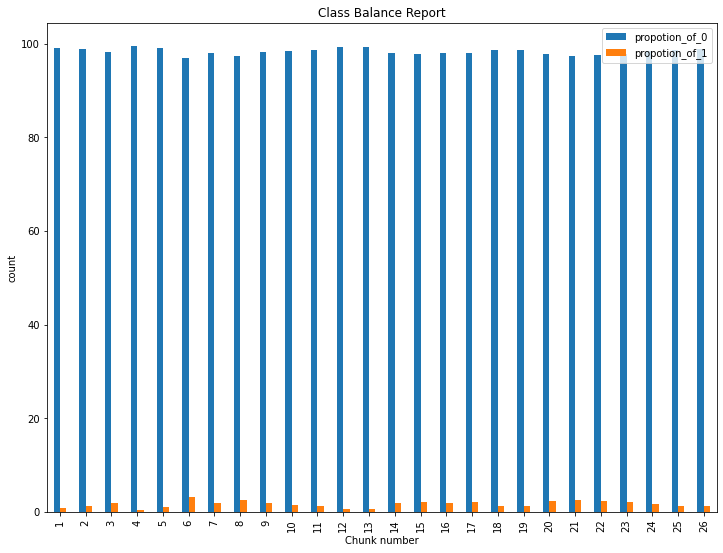

In [ ]:
# Generate group bar chart showing the class balance report

index = class_balance_report["chunk number"]

df = class_balance_report[["propotion_of_0","propotion_of_1"]]
df.index = index
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12, 9]
ax = df.plot.bar()
plt.title("Class Balance Report")
plt.xlabel("Chunk number")
plt.ylabel("count")

**- The class balance report and the barchart showing the distribution of class 0 and class 1 in each batch or chunk clearly shows that the data set is highly skewed with majority of data belongs to class 0 in each chunk**

### **3.2. Handling extremely unbalanced data sets**

- Since we have very skewed data , each chunk contains 99% class 0
- One option is to subsample the majority class (reduce the number of majority class data)
- We also consider the distribution of y (which is unbalanced) in training model when making test and train splits by putting stratify = y. This will ensure that the splits contain target data just like the distribution of imbalanced target.

### **3.3 Save each chunk as csv** ( additional function to save chunk and perform tests)

In [ ]:
# Make a function to save chunks as csv. We save chunk 3 see below.
def save_chunk_as_csv(input_csv):

    data_iterator = pd.read_csv(input_csv, chunksize=500000,iterator=True)


    chunk_num =0
    
    for data_chunk in data_iterator:
    
        chunk_num = chunk_num +1   
    # save the cunks as seperate csv files
        if chunk_num == 3:
            data_chunk.to_csv(str(input_csv[:-4])+"_chunk_"+str(chunk_num)+'.csv',index=False)



In [ ]:
save_chunk_as_csv("X_train_250.csv")

In [ ]:
save_chunk_as_csv("y_train_250.csv")

## **4. Learning curve to decide how many data sets do we need for best performance** 

https://www.dataquest.io/blog/learning-curves-machine-learning/

- We plot learning curves for test data and train data to find how many batches are required to build a model with good performance
- We start by plotting learning curves for a single batch, to see how our model is able to generalize over only a small subset of the data. After our explorative analysis we found that batch 3 seems to be a representative batch.

http://rasbt.github.io/mlxtend/user_guide/plotting/plot_learning_curves/



In [ ]:
X_data_c3 = pd.read_csv("X_train_250_chunk_3.csv")
y_data_c3 = pd.read_csv("y_train_250_chunk_3.csv")

In [ ]:
X_data_c3.shape

(500000, 64)

In [ ]:
y_data_c3.shape

(500000, 1)

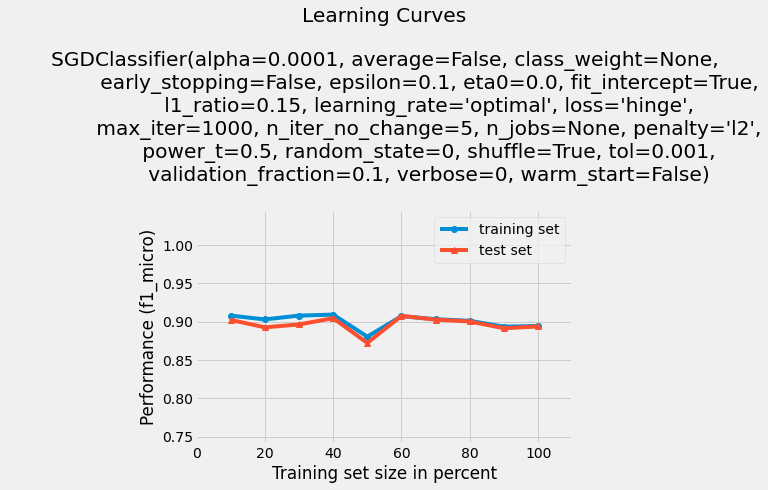

In [ ]:
# Need to fix the shape of y_data_c3 to make it work with our learning curves
y_data_c3 = y_data_c3.values
y_data_c3 = y_data_c3.reshape(y_data_c3.shape[0],)

# Plot curves chunk 3

sc = StandardScaler()
sc.fit(X_data_c3, y_data_c3)
sgd = SGDClassifier(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_data_c3, y_data_c3, test_size=0.3,
                                                    random_state=12)
plot_learning_curves(X_train, y_train, X_test, y_test, sgd, scoring='f1_micro')
plt.show()

At around 60 percent of the training set the f1 micro averaged score, does not seem to improve. The performance on the test set is at its highest. 

The f1 micro averaged score sums up true positives, false positives and false negatives for different subsets of the training data and averaging.

## **5. Feature selection through assessing feature importance**

Use random forest to measure feature importance.
Feature importance measured from the average impurity decrease from all the decision trees.
Then we average over all the batches. (Raschka, chapter 4, 2019)

In [ ]:
# Approx 15-20 minutes with n_estimators=50
# Make iterators
csv_iterator_X = pd.read_csv("X_train_250.csv", chunksize=500000)
csv_iterator_y = pd.read_csv("y_train_250.csv", chunksize=500000)

forest = RandomForestClassifier(n_estimators=50, random_state=1,
                                n_jobs=-1, verbose=1)

count = 0

# Zero array with number of features
importances = np.zeros(64)


for batch in zip(csv_iterator_X, csv_iterator_y):
    count += 1
    print("Batch: ", count)
    X_batch = batch[0]
    # Use ravel to avoid warning
    y_batch = np.ravel(batch[1])
    # New fit for each batch
    forest.fit(X_batch, y_batch)
    # Add feature importance for batch to array
    importances += forest.feature_importances_

# Average over all importances
importances /= count

 1) L64                            0.183750
 2) L56                            0.091031
 3) L39                            0.078401
 4) L43                            0.073673
 5) L41                            0.062115
 6) L61                            0.060806
 7) L60                            0.048712
 8) L58                            0.043003
 9) L16                            0.041584
10) L33                            0.025512
11) L45                            0.023912
12) L18                            0.023898
13) L31                            0.023591
14) L47                            0.018752
15) L27                            0.016097
16) L63                            0.015445
17) L8                             0.012349
18) L57                            0.011744
19) L46                            0.011492
20) L44                            0.011486
21) L40                            0.010158
22) L52                            0.009798
23) L23                         

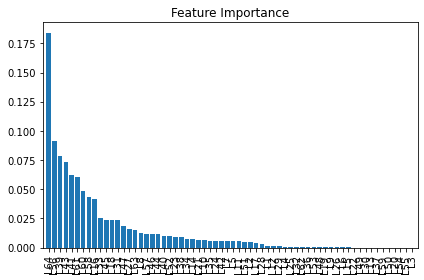

In [ ]:

# Make plot of feature importances for entire data set. Source "Raschka, chpt 4"

indices = np.argsort(importances)[::-1]
# Getting labels from the last batch
feat_labels = X_batch.columns

for f in range(X_batch.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_batch.shape[1]),
        importances[indices])
plt.xticks(range(X_batch.shape[1]),
          feat_labels[indices], rotation=90)
plt.xlim([-1, X_batch.shape[1]])
plt.tight_layout()

In [ ]:
# Rank feature labels

ranked_feat_labels = []
for f in range(X_batch.shape[1]):
    ranked_feat_labels.append(feat_labels[indices[f]])
    
print(ranked_feat_labels)
# Save ranked feat labels
# with open(r"/content/drive/MyDrive/ca3/feat_ranked_est50.txt", "w") as file:
    # file.write(str(ranked_feat_labels))

In [ ]:
with open("/content/drive/MyDrive/ca3/feat_ranked_est50.txt", "r") as file:
    ranked_feat_labels = eval(file.readline())

Tried using 20 and 40 features, however it did not improve the results. 

## **6. Training the model**

## SGD Classifier - linear Support Vector Machine

- Since the the data is huge we use classifiers that support partial fit (incremental learning) , the attribute **"classes=range(2)"** is set to define that this is a binary classification problem . (also depending on the loss fuction we choose we can chosse logistic regression or SVM classifier)
- We train the model on training data on multiple batches of **chunk size 500000** , thus covering the whole training data  without crashing the memory. 
- SGD classifiers have an attribute class_weight , which can be set to " balanced in normal cases , **but this attribute cannot be set to balanced when we are using partial fit.**
-  By default it uses a SVM , **making the loss as log it becomes logistic regression**



### **6.1 PERFORMANCE METRICS**

Since the data is highly unbalanced accuracy cannot be used as a metric for measuring the model performace , as even a badly performing model would result in a high accuracy because of the highly skewed data set , with majority belonging to class 1 ie: not cancerous pixels, therefore f1 score is a preferred metric for performance measurement.

### **6.2 Learning curve showing the variation in performace vs batches seen (each batch is of size 500,000 and there are a total of 26 batches)**

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV
# -*- coding: utf-8 -*-
"""
Learning curve for many batches
"""


# =============================================================================
# Import modules
# =============================================================================
import pandas as pd
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight

# =============================================================================
# Load data
# =============================================================================

# =============================================================================
# Fit StandardScaler across all batches
# =============================================================================

x = zipfile.ZipFile('X_train_250.csv.zip') 
y = zipfile.ZipFile('y_train_250.csv.zip') 


part_sc = StandardScaler()

#for i, df in enumerate(vaex.from_csv(zf.open('X_train_250.csv'), chunk_size=200_000)):

iterator_x = pd.read_csv(x.open('X_train_250.csv'), chunksize=500_000) # pandas initiate an iterator 
iterator_y = pd.read_csv(y.open('y_train_250.csv'), chunksize=500_000)


# =============================================================================
# Initialise and train model
# =============================================================================
sgd = SGDClassifier(random_state = 0)


# Initialise for later use, see loop
y_pred_test = np.zeros(0)
y_test = np.zeros(0)
y_pred_train = np.zeros(0)
y_train = np.zeros(0)

f1_scores_test =[]
f1_scores_train = []
b = 0
for batch in zip(iterator_x, iterator_y):
    b = b+1
    print("B",b)
    X = batch[0]
    y = np.ravel(batch[1])
    X_train_batch, X_test_batch, y_train_batch, y_test_batch = train_test_split(X, y, stratify=y, test_size=0.3, random_state=2)
        # we transform the training and test data with the mean and standard deviation 
        # across all the training data
        # use stratify = y to handle the imbalanced data sampling
    part_sc.partial_fit(X_train_batch, y_train_batch)
   # class_weights = class_weight.compute_class_weight('balanced',
    #                                             np.unique(y_train_batch),
     #                                            y_train_batch)
    sgd.partial_fit(part_sc.transform(X_train_batch), y_train_batch,classes=range(2) ) 
        # specify the number of classes
    y_batch_pred_train = sgd.predict(part_sc.transform(X_train_batch))
    y_pred_train = np.concatenate((y_pred_train, y_batch_pred_train))
    y_train = np.concatenate((y_train, y_train_batch))
    batch_f1_score_train = f1_score(y_true=y_train_batch, y_pred=y_batch_pred_train)
    f1_scores_train.append(batch_f1_score_train)
    
    y_batch_pred_test = sgd.predict(part_sc.transform(X_test_batch))
    y_pred_test = np.concatenate((y_pred_test, y_batch_pred_test))
    y_test = np.concatenate((y_test, y_test_batch))
    batch_f1_score_test = f1_score(y_true=y_test_batch, y_pred=y_batch_pred_test)
    f1_scores_test.append(batch_f1_score_test)


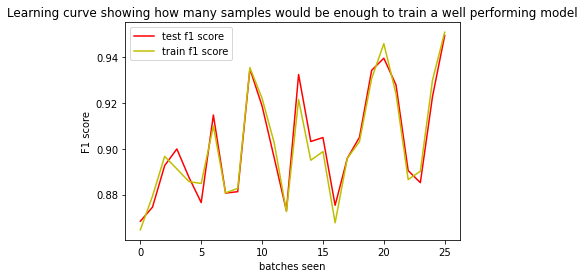

In [ ]:
# Plot generalisation performance
plt.plot(f1_scores_test, 'r',label = "test f1 score")
plt.plot(f1_scores_train, 'y',label = "train f1 score")

plt.title("Learning curve showing how many samples would be enough to train a well performing model")
plt.xlabel("batches seen")
plt.ylabel("F1 score")
plt.legend()

In [ ]:
f1_scores_test

[0.8616187989556137,
 0.8632075471698113,
 0.8876985592907277,
 0.8778979907264297,
 0.8825674690007294,
 0.8769505127061971,
 0.9091210613598674,
 0.8772702256466705,
 0.8746411483253588,
 0.9293391264578094,
 0.9166897315250483,
 0.8809416025350836,
 0.8460217515741272,
 0.9184415584415584,
 0.8995809405556419,
 0.8950033760972316,
 0.861917623227549,
 0.8875896890778634,
 0.8935329003106467,
 0.9219098616688978,
 0.9401665598975016,
 0.9249538941693858,
 0.8828279750114276,
 0.8881538143477362,
 0.9184709970596099,
 0.9294532627865962]

- We see good performance with a batch size of 5 from the F1 score plot above .But if we increase the batchsize to just 10 the performance further improves and adding on more batches does not increase the performance considerably . 

- Which means that we don't need the whole data set to build good models to solve the binary classification problem.a batch size of 10 is optimum for a building a good performing model which generalises the the training data.

### **6.3 Confusion matrix**
We plot a confusion matrix to get a better overview of our predicted labels compared to the true labels

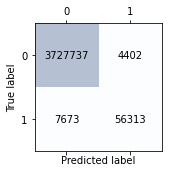

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

Confusion matrix shows that
- True negatives is extremly high compared to the rest of the other categories.
- This confirms accuracy is thus not a good metric for our problem.
- Our model should be able to predict a high true positive rate.
- Also in cancer detection it is particularly important to keep false negatives low
- F1 score is a better metric to balance this need

## **7. Predictions**
( training on the whole data set)

In [ ]:
X_test = zipfile.ZipFile('X_test_100.csv.zip') 
X_test = pd.read_csv(X_test.open('X_test_100.csv'))

In [ ]:
# Train on whole data set

x = zipfile.ZipFile('X_train_250.csv.zip') 
y = zipfile.ZipFile('y_train_250.csv.zip') 
iterator_x = pd.read_csv(x.open('X_train_250.csv'), chunksize=500_000) # pandas initiate an iterator 
iterator_y = pd.read_csv(y.open('y_train_250.csv'), chunksize=500_000)
for batch in zip(iterator_x, iterator_y):
    X = batch[0]
    y = np.ravel(batch[1])
    part_sc.partial_fit(X, y)
    sgd.partial_fit(part_sc.transform(X), y, classes=range(2)) 


In [ ]:
y_pred = sgd.predict(X_test)

In [ ]:
y_pred = np.where(y_pred == 0, 'False','True')

In [ ]:
y_pred.shape

(5061500,)

In [ ]:
ID = np.arange(0,len(y_pred))
h = np.column_stack((ID,y_pred))
df = pd.DataFrame(data=h)

In [ ]:
df.columns=['Id','Predicted'] 
df.to_csv(r'predict04.csv', index = False)

In [ ]:
!kaggle competitions submit -c dat300-h2020-ca3 -f predict04.csv -m "prediction 4 submission"

In [ ]:
!kaggle competitions submit -c dat300-h2020-ca3 -f predict02.csv -m "prediction 2 submission"

### **SGD with many iterations**

To check if more iterations help in improving the f1 score

If the score is incresing it means more iterations helps in improving the results

In [ ]:
# -*- coding: utf-8 -*-
"""
Many iterations(epochs), many batches, scales in batches
 and trains in batches 
"""

# =============================================================================
# Import modules
# =============================================================================
from sklearn.utils.class_weight import compute_class_weight
# =============================================================================
# Fit StandardScaler across all batches
# =============================================================================

x = zipfile.ZipFile('X_train_250.csv.zip') 
y = zipfile.ZipFile('y_train_250.csv.zip') 


part_sc = StandardScaler()

#for i, df in enumerate(vaex.from_csv(zf.open('X_train_250.csv'), chunk_size=200_000)):

# =============================================================================
# Initialise and train model
# =============================================================================
sgd = SGDClassifier(random_state=0, loss = "log" )
# by defauls it is a linear SVM , bu changing the loss to log 
# we can make it a logistic regression


# Initialise for later use, see loop
y_pred_test = np.zeros(0)
y_test = np.zeros(0)
y_pred_train = np.zeros(0)
y_train = np.zeros(0)

f1_scores_test =[]
f1_scores_train = []


for iteration in range(5):
    x = zipfile.ZipFile('X_train_250.csv.zip') 
    y = zipfile.ZipFile('y_train_250.csv.zip') 

    iterator_x = pd.read_csv(x.open('X_train_250.csv'), chunksize=500_000) # pandas initiate an iterator 
    iterator_y = pd.read_csv(y.open('y_train_250.csv'), chunksize=500_000)
    print("Iteration", iteration)
    for batch in zip(iterator_x, iterator_y):
        X = batch[0]
        y = np.ravel(batch[1])
        X_train_batch, X_test_batch, y_train_batch, y_test_batch = train_test_split(X, y, test_size=0.3, random_state=2)
        # we transform the training and test data with the mean and standard deviation 
        # across all the training data
        part_sc.partial_fit(X_train_batch, y_train_batch)
        sgd.partial_fit(part_sc.transform(X_train_batch), y_train_batch, classes=range(2))
    y_batch_pred_train = sgd.predict(part_sc.transform(X_train_batch))
    y_pred_train = np.concatenate((y_pred_train, y_batch_pred_train))
    y_train = np.concatenate((y_train, y_train_batch))
    batch_f1_score_train = f1_score(y_true=y_train_batch, y_pred=y_batch_pred_train)
    f1_scores_train.append(batch_f1_score_train)
    
    y_batch_pred_test = sgd.predict(part_sc.transform(X_test_batch))
    y_pred_test = np.concatenate((y_pred_test, y_batch_pred_test))
    y_test = np.concatenate((y_test, y_test_batch))
    batch_f1_score_test = f1_score(y_true=y_test_batch, y_pred=y_batch_pred_test)
    f1_scores_test.append(batch_f1_score_test)
   

In [ ]:
# SVM, trained for 5 iteration using the default f1 score
# where average = "binary"

f1_scores_test 

[0.9294532627865962,
 0.928759894459103,
 0.9303135888501741,
 0.9316017316017317,
 0.9339055793991418]

In [ ]:
# Logistic regression classifier , trained for 5 iteration using the default f1 score
# where average = "binary"

f1_scores_test 

[0.9264836138175377,
 0.9268722466960353,
 0.929380993897123,
 0.9335634167385677,
 0.9369676320272572]

We could observe that there are no big difference in the performance of the model when using a logistic regression classifier in place of a SVM

## **Learning curve showning F1 score vs iterations**

The plot shows that the f1 score increase as iterations increases

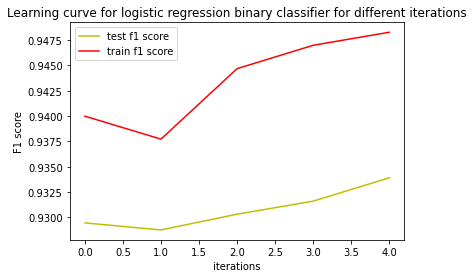

In [ ]:
# Plot generalisation performance
plt.plot(f1_scores_test, "y",label="test f1 score")
plt.plot(f1_scores_train, "r",label="train f1 score")
plt.title("Learning curve for logistic regression binary classifier for different iterations")
plt.xlabel("iterations")
plt.xticks(range(5))
plt.ylabel("F1 score")
plt.legend()


In [ ]:
f1_scores_test

[0.9264836138175377,
 0.9268722466960353,
 0.929380993897123,
 0.9335634167385677,
 0.9369676320272572]

In [ ]:
# Train on whole data set

for iteration in range(5):
    print(iteration)
    x = zipfile.ZipFile('X_train_250.csv.zip') 
    y = zipfile.ZipFile('y_train_250.csv.zip') 
    iterator_x = pd.read_csv(x.open('X_train_250.csv'), chunksize=500_000) # pandas initiate an iterator 
    iterator_y = pd.read_csv(y.open('y_train_250.csv'), chunksize=500_000)

    for batch in zip(iterator_x, iterator_y):
       X = batch[0]
       y = np.ravel(batch[1])
       part_sc.partial_fit(X, y)
       sgd.partial_fit(part_sc.transform(X), y, classes=range(2)) 

In [ ]:
y_pred = np.zeros(0)
X_test = zipfile.ZipFile('X_test_100.csv.zip')
iterator_X_test = pd.read_csv(X_test.open("X_test_100.csv"), chunksize=500_000)

for batch in iterator_X_test:
    print(len(y_pred))
    count_X_test += 1
    print("batch X_test", count_X_test)
    X_test = batch
    y_pred_batch = sgd.predict(X_test)
    y_pred = np.concatenate((y_pred, y_pred_batch))

In [ ]:
# generating results for submission to kaggle
y_pred = np.where(y_pred == 0, 'False','True')

ID = np.arange(0,len(y_pred))
h = np.column_stack((ID,y_pred))
df = pd.DataFrame(data=h)


df.columns=['Id','Predicted'] 
df.to_csv(r'predict_ah13.csv', index = False)

In [ ]:
!kaggle competitions submit -c dat300-h2020-ca3 -f predict_ah13.csv -m "logistic regression 5 iterations  "

100% 66.5M/66.5M [00:00<00:00, 85.5MB/s]
Successfully submitted to DAT300 - H2020 - CA3

##======================END OF TASK=========================

## **Conclusion :** 

- We tried with different startegies for out of core learning https://scikit-learn.org/0.15/modules/scaling_strategies.html 
using SGD classifier (SVM and logistic regression ) and the passive aggresive classifier . 

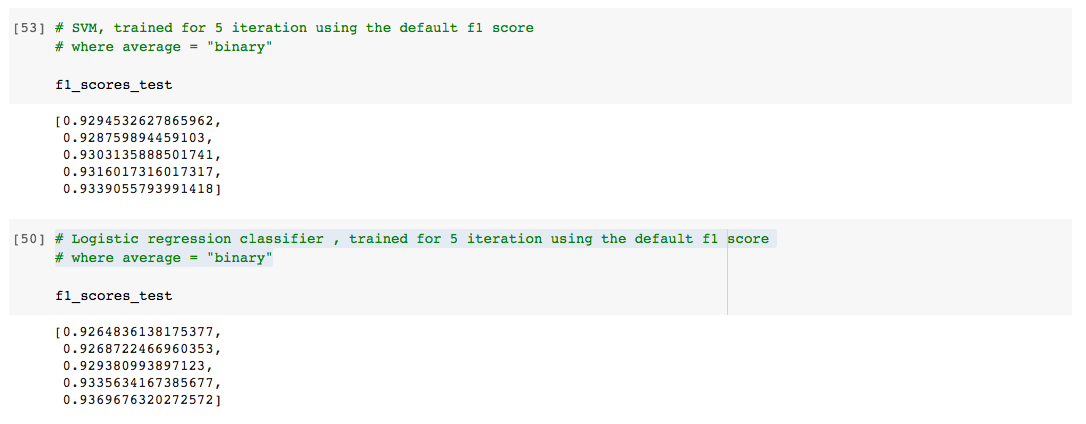


- We observed that we were getting alsmost similar f1 scores for both here .But on kaggle we got better results with a logic regression classifier with 5 iterations "predict13.csv" F1 score :0.90091 .
while for SVM when trained for 5 iteration we got a f1 score: 0.88986

- We tried to perform feature selection , by using feature importance method based on random forest and reduced the number of features from 64 to 40 and 20 , but there was no considerable increase in the performance. Score 0.86478 with 40 features. 

- We therefore chose the logistic regression for 5 iterations  as our best performing model for the final submission.

